This notebook pulls the data from the Features.parquet file and is used to validate that we preseve the data accross saves to parquet format. Data should compare with the develop_simple_features.ipynb

In [3]:
# save the variance explained to a pickle file
import joblib
import warnings
from io import BytesIO
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
from PIL import Image

try:
    from sklearnex import patch_sklearn
except ImportError:
    %pip install scikit-learn-intelex
    from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.decomposition import PCA

# apply TSNE to the Hue, Value, and LBP features
from sklearn.manifold import TSNE

from feature_utils import normalize_histogram

warnings.filterwarnings("ignore")

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [4]:
# Read the parquet file, this takes a while. Leave it here
features_file = Path("data/train_features.parquet")
if not features_file.exists():
    print("No features file found. Please run the create_features_table first")
    exit(1)

meta_file = Path("data/meta_full.parquet")
if not meta_file.exists():
    print("No features file found. Please run the create_features_table first")
    exit(1)

dft = pl.read_parquet(features_file, memory_map=True)
dfm = pl.read_parquet(meta_file, memory_map=True)
dft = dft.join(dfm, on="ClassId")
samples_per_class = 200
random_seed = 42
pl.set_random_seed(random_seed)
dft = pl.concat(
    [
        x.sample(samples_per_class, with_replacement=False, shuffle=False)
        for x in dft.partition_by("ClassId")
    ]
)
# del dfm

In [5]:
dft.head(1)

id,ClassId,Width,Height,Image,Resolution,Scaled_Meta_Image,Hue_Hist,Saturation_Hist,Value_Hist,LBP_Image,LBP_Hist,HOG_Features,HOG_Image,Template_Pattern,RESNET101,VGG16,Path,ShapeId,ColorId,SignId,Description,Meta_Image,Meta_Width,Meta_Height,Meta_Resolution,Scaled_Meta_Width,Scaled_Meta_Height,Scaled_Meta_Image_right,Scaled_Meta_Resolution
i64,i64,i64,i64,binary,i64,binary,list[i64],list[i64],list[i64],binary,list[i64],list[f32],binary,list[f32],list[f64],list[f64],str,i64,i64,str,str,binary,i64,i64,i64,i64,i64,binary,i64
0,20,64,64,[binary data],4096,[binary data],"[9, 0, … 0]","[4, 0, … 0]","[0, 0, … 0]",[binary data],"[102, 133, … 0]","[0.167095, 0.034354, … 0.129399]",[binary data],"[0.260097, 0.244527, … 0.093958]","[0.739312, 0.0, … 0.0]","[0.0, 0.0, … 0.0]","""/work/06333/ed…",0,0,"""1.1""","""Right curve""",[binary data],88,100,8800,64,64,[binary data],4096


In [6]:
dft.shape

(8600, 30)

In [7]:
# get the list of columns from the dataframe
columns = dft.columns
columns

['id',
 'ClassId',
 'Width',
 'Height',
 'Image',
 'Resolution',
 'Scaled_Meta_Image',
 'Hue_Hist',
 'Saturation_Hist',
 'Value_Hist',
 'LBP_Image',
 'LBP_Hist',
 'HOG_Features',
 'HOG_Image',
 'Template_Pattern',
 'RESNET101',
 'VGG16',
 'Path',
 'ShapeId',
 'ColorId',
 'SignId',
 'Description',
 'Meta_Image',
 'Meta_Width',
 'Meta_Height',
 'Meta_Resolution',
 'Scaled_Meta_Width',
 'Scaled_Meta_Height',
 'Scaled_Meta_Image_right',
 'Scaled_Meta_Resolution']

In [8]:
columns_feature = [
    "Hue_Hist",
    "Saturation_Hist",
    "LBP_Image",
    "HOG_Features",
    "Template_Pattern",
]

In [10]:
# get features from each column in the dataframe


def get_lbp_features(df, columns):
    features = []
    numpy_stage1_train = df.with_columns(
        pl.col(columns[0]).map_elements(lambda x: np.load(BytesIO(x))).alias("NumPy")
    )
    X_train_LBP = np.asarray(numpy_stage1_train["NumPy"].to_list())
    del numpy_stage1_train
    X_train_LBP = np.reshape(
        X_train_LBP, (X_train_LBP.shape[0], X_train_LBP.shape[1] * X_train_LBP.shape[2])
    )
    return X_train_LBP


def get_features(df, columns):
    features = []
    for column in columns:
        # if column has more than one value, then vstack the values
        if len(df[column][0]) > 1:
            features.append(np.vstack(df[column]))
        else:
            features.append(df[column])
    # convert features to numpy array
    features = np.hstack(features)
    return features

In [11]:
hue = get_features(dft, ["Hue_Hist"])
saturation = get_features(dft, ["Saturation_Hist"])
lbp = get_lbp_features(dft, ["LBP_Image"])
hog = get_features(dft, ["HOG_Features"])
template = get_features(dft, ["Template_Pattern"])

In [13]:
print(
    "Hue Shape is:",
    hue.shape,
    "\n",
    "saturation Shape is:",
    saturation.shape,
    "\n",
    "LBP shape is:",
    lbp.shape,
    "\n",
    "HOG shape is:",
    hog.shape,
    "\n",
    "Template shape is:",
    template.shape,
    "\n",
)

Hue Shape is: (8600, 180) 
 saturation Shape is: (8600, 256) 
 LBP shape is: (8600, 4096) 
 HOG shape is: (8600, 2916) 
 Template shape is: (8600, 3483) 



In [14]:
# all features combined
features_total = np.hstack([hue, saturation, lbp, hog, template])
features_total.shape

(8600, 10931)

In [15]:
# get HOG and Template features
features_hog_template = np.hstack([hog, template])
features_hog_template.shape

(8600, 6399)

In [59]:
#hue, hog, template features
features_hue_hog_template = np.hstack([hue, hog, template])
features_hue_hog_template.shape

(8600, 6579)

In [60]:
import pandas as pd

# create a dataframe to store the features size

features_size = pd.DataFrame(
    [
        ["Hue", hue.shape[1]],
        ["Saturation", saturation.shape[1]],
        ["LBP", lbp.shape[1]],
        ["HOG", hog.shape[1]],
        ["Template", template.shape[1]],
        ["HOG + Template", features_hog_template.shape[1]],
        ["Hue + HOG + Template", features_hue_hog_template.shape[1]],
        ["Total", features_total.shape[1]],
    ],
    columns=["Feature", "Size"],
)
features_size




,Feature,Size
0,Hue,180
1,Saturation,256
2,LBP,4096
3,HOG,2916
4,Template,3483
5,HOG + Template,6399
6,Hue + HOG + Template,6579
7,Total,10931


In [61]:
# define PCA function to get variance explained


def get_variance_explained(feature):
    pca = PCA()  # did not specify number of components
    pca.fit(feature)
    individual_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    return individual_variance, cumulative_variance

In [62]:
variance_explained_file = Path("data/variance_explained.joblib")
if not variance_explained_file.exists():
    hue_variance = get_variance_explained(hue)
    saturation_variance = get_variance_explained(saturation)
    lbp_variance = get_variance_explained(lbp)
    hog_variance = get_variance_explained(hog)
    template_variance = get_variance_explained(template)
    hog_template_variance = get_variance_explained(features_hog_template)
    hue_hog_temp_variance = get_variance_explained(features_hue_hog_template)
    total_variance = get_variance_explained(features_total)
    joblib.dump(
        {
            "hue": hue_variance,
            "sat": saturation_variance,
            "lbp": lbp_variance,
            "hog": hog_variance,
            "tem": template_variance,
            "hog_tem": hog_template_variance,
            "hue_hog_temp": hue_hog_temp_variance,
            "tot": total_variance,
        },
        variance_explained_file,
    )
else:
    loaded_var = joblib.load(variance_explained_file)
    hue_variance = loaded_var["hue"]
    saturation_variance = loaded_var["sat"]
    lbp_variance = loaded_var["lbp"]
    hog_variance = loaded_var["hog"]
    template_variance = loaded_var["tem"]
    hog_template_variance = loaded_var["hog_tem"]
    hue_hog_temp_variance = loaded_var["hue_hog_temp"]
    total_variance = loaded_var["tot"]

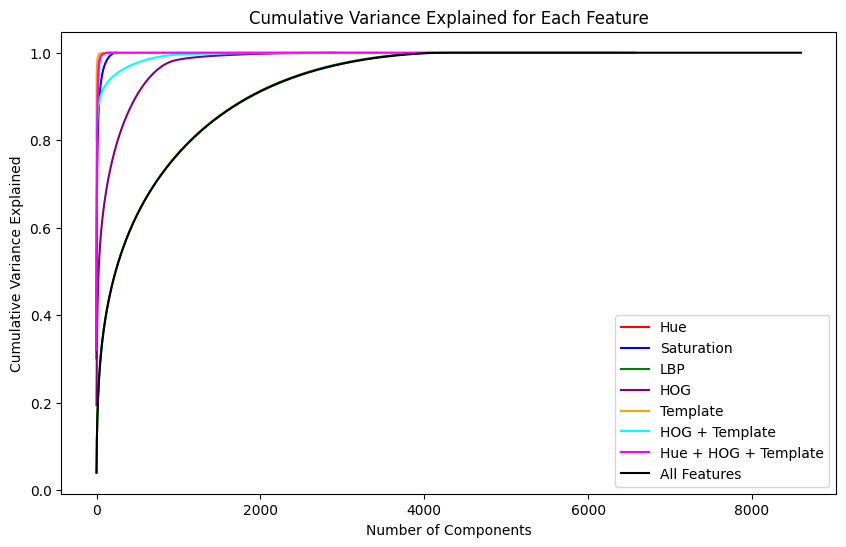

In [68]:
# plot variance explained of all features

variance_list = [
    hue_variance,
    saturation_variance,
    lbp_variance,
    hog_variance,
    template_variance,
    hog_template_variance,
    hue_hog_temp_variance,
    total_variance,
]
title = [
    "Hue",
    "Saturation",
    "LBP",
    "HOG",
    "Template",
    "HOG + Template",
    "Hue + HOG + Template",
    "All Features",
]


def plot_variance_visual(variance_list, title):
    # define figure size and subplots
    fig = plt.figure(figsize=(10, 6))

    # use different colors for each feature
    colors = ["red", "blue", "green", "purple", "orange", "cyan", "magenta", "black"]

    # # plot the individual variance explained for each feature in the same plot
    # for i in range(len(variance_list)):
    #     plt.plot(variance_list[i][0], color=colors[i], label=title[i])
    # plt.legend()


    # plot the cumulative variance explained for each feature in the same plot
    for i in range(len(variance_list)):
        plt.plot(variance_list[i][1], color=colors[i],label=title[i])
    plt.legend()
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Variance Explained")
    plt.title("Cumulative Variance Explained for Each Feature")
    plt.show()


# plot individual and cumulative variance explained
def plot_variance_compare(variance_vec, cust_title):
    # define figure size and subplots
    fig = plt.figure(figsize=(10, 6))

    plt.bar(
        range(0, len(variance_vec[0])),
        variance_vec[0],
        alpha=0.5,
        align="center",
        label="Individual explained variance",
    )
    plt.step(
        range(0, len(variance_vec[1])),
        variance_vec[1],
        where="mid",
        label="Cumulative explained variance",
    )
    plt.legend(loc="best")
    plt.xlabel("Number of Components")
    plt.ylabel("Variance Explained")
    plt.title(cust_title)
    plt.show()


plot_variance_visual(variance_list, title)

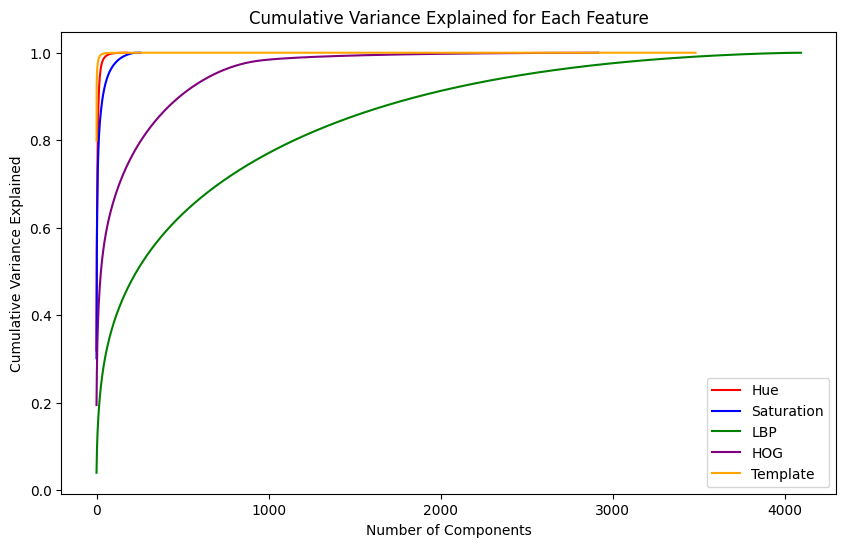

In [78]:
variance_list_individual = [
    hue_variance,
    saturation_variance,
    lbp_variance,
    hog_variance,
    template_variance,
]
title_individual = [
    "Hue",
    "Saturation",
    "LBP",
    "HOG",
    "Template",
]

plot_variance_visual(variance_list_individual, title_individual)

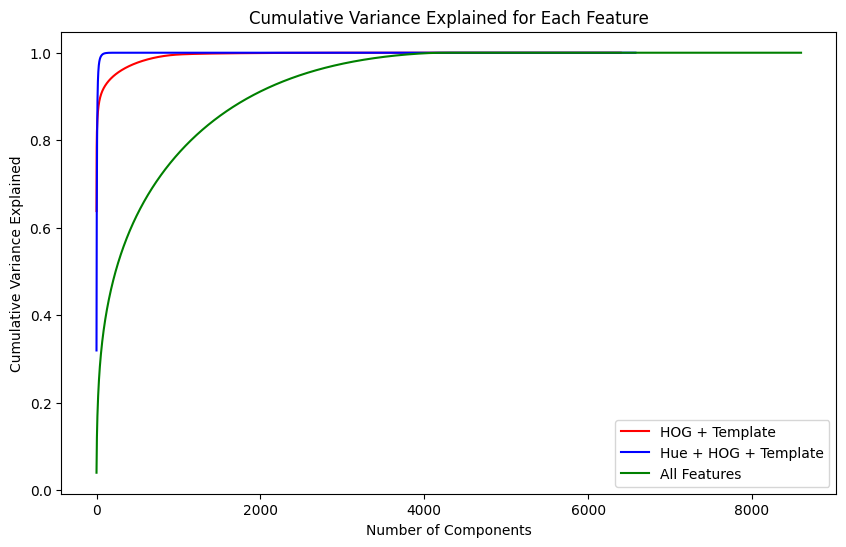

In [80]:
variance_list_combined = [
    hog_template_variance,
    hue_hog_temp_variance,
    total_variance,
]
title_combined = [
    "HOG + Template",
    "Hue + HOG + Template",
    "All Features",
]

plot_variance_visual(variance_list_combined, title_combined)

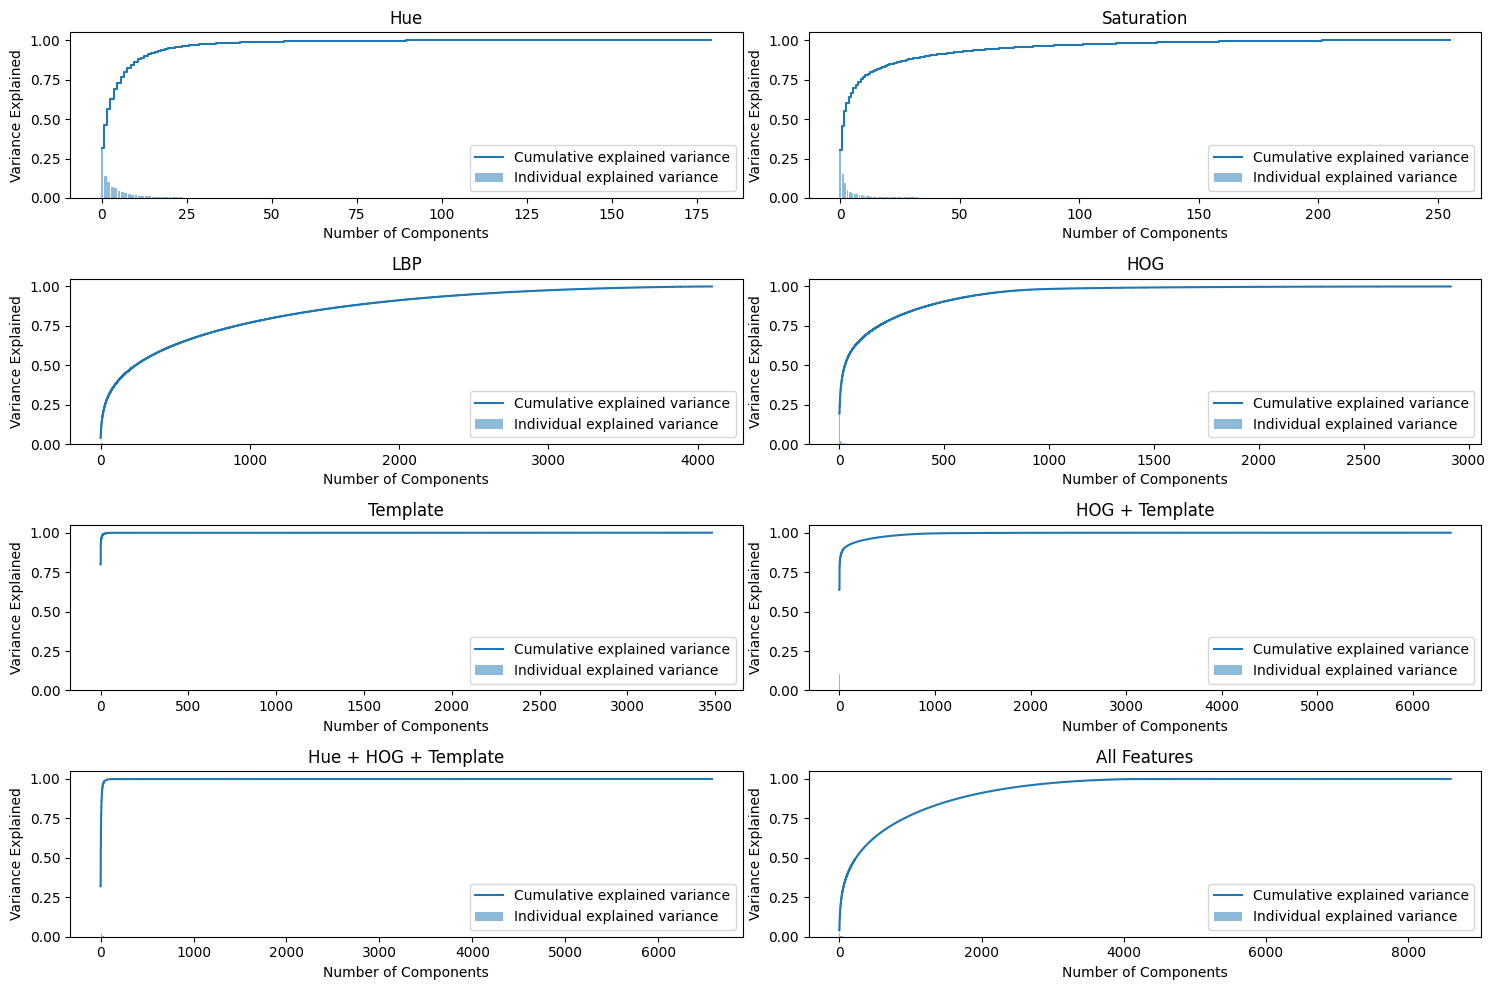

In [69]:
# create subplots for each feature, 3 rows and 2 columns
fig, axes = plt.subplots(4, 2, figsize=(15, 10))
for i in range(len(variance_list)):
    axes[i // 2, i % 2].bar(
        range(0, len(variance_list[i][0])),
        variance_list[i][0],
        alpha=0.5,
        align="center",
        label="Individual explained variance",
    )
    # add step graph to plot cumulative variance explained
    axes[i // 2, i % 2].step(
        range(0, len(variance_list[i][1])),
        variance_list[i][1],
        where="mid",
        label="Cumulative explained variance",
    )
    # add legend
    axes[i // 2, i % 2].legend(loc="best")
    # add title
    axes[i // 2, i % 2].set_title(title[i])
    axes[i // 2, i % 2].set_xlabel("Number of Components")
    axes[i // 2, i % 2].set_ylabel("Variance Explained")

plt.tight_layout()
plt.show()

In [70]:
# select the top components in features_total that explain 95% of the variance
pca_total_file = Path("data/pca_total.joblib")
if not pca_total_file.exists():
    pca = PCA(n_components=0.95)
    pca.fit(features_total)
    joblib.dump(pca, pca_total_file)
else:
    pca = joblib.load(pca_total_file)
print("Number of components that explain 95% of the variance:", pca.n_components_)
features_total_pca = pca.transform(features_total)
print("Shape of features_total_pca:", features_total_pca.shape)

Number of components that explain 95% of the variance: 2507
Shape of features_total_pca: (8600, 2507)


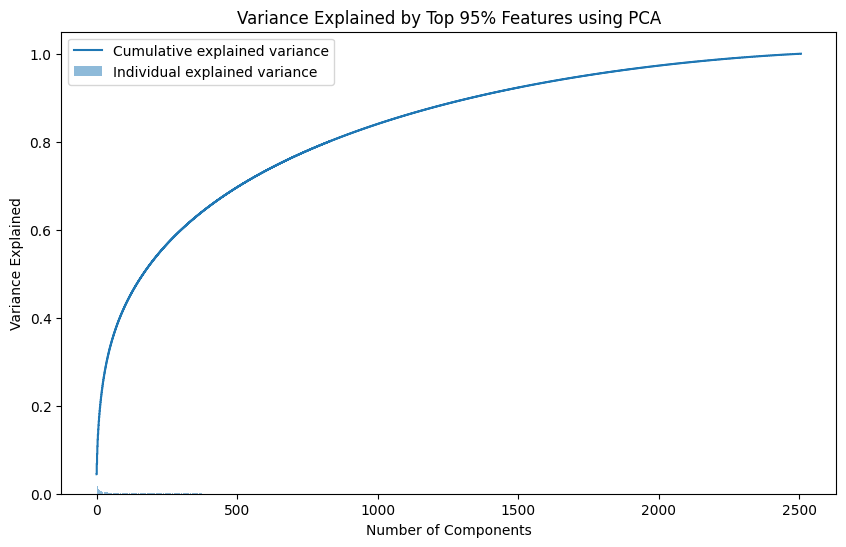

In [71]:
total_variance_pca = get_variance_explained(features_total_pca)
title_pca = "Variance Explained by Top 95% Features using PCA"
plot_variance_compare(total_variance_pca, title_pca)

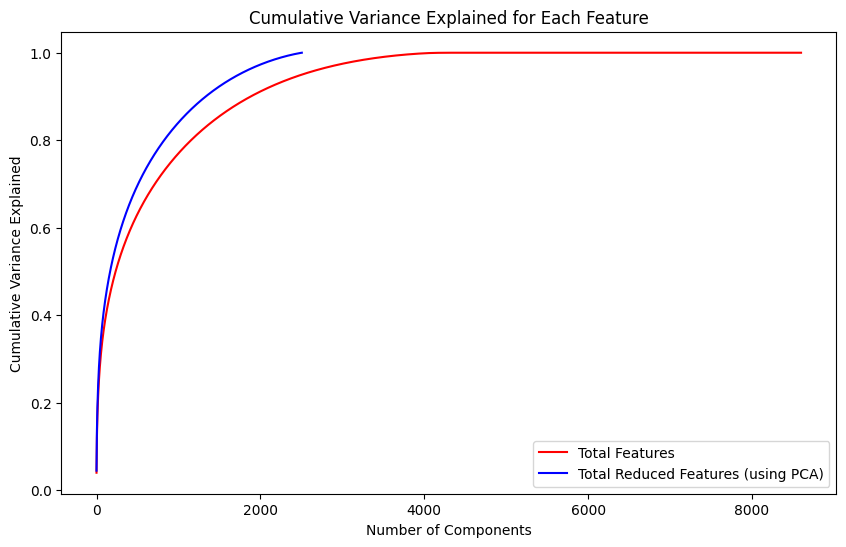

In [72]:
# plot total_variance_pca and total_variance in the same plot
sub_variance_list = [
    total_variance,
    total_variance_pca,
]
title_2 = [
    "Total Features",
    "Total Reduced Features (using PCA)",
    
]

plot_variance_visual(sub_variance_list, title_2)


In [73]:
features_total_pca.shape


# save features_total_pca to a csv file
features_total_pca_file = Path("data/features_total_pca.csv")
if not features_total_pca_file.exists():
    np.savetxt(features_total_pca_file, features_total_pca, delimiter=",")
else:
    features_total_pca = np.loadtxt(features_total_pca_file, delimiter=",")
print("Shape of features_total_pca:", features_total_pca.shape)



Shape of features_total_pca: (8600, 2507)


In [74]:
# select the top components in features_hog_template that explain 95% of the variance   
pca_hog_template_file = Path("data/pca_hog_template.joblib")
if not pca_hog_template_file.exists():
    pca = PCA(n_components=0.95)
    pca.fit(features_hog_template)
    joblib.dump(pca, pca_hog_template_file)
else:
    pca = joblib.load(pca_hog_template_file)
print("Number of components that explain 95% of the variance:", pca.n_components_)
features_hog_template_pca = pca.transform(features_hog_template)
print("Shape of features_hog_template_pca:", features_hog_template_pca.shape)


Number of components that explain 95% of the variance: 231
Shape of features_hog_template_pca: (8600, 231)


In [75]:
# save features_hog_template_pca to a csv file
features_hog_template_pca_file = Path("data/features_hog_template_pca.csv")
if not features_hog_template_pca_file.exists():
    np.savetxt(features_hog_template_pca_file, features_hog_template_pca, delimiter=",")
else:
    features_hog_template_pca = np.loadtxt(features_hog_template_pca_file, delimiter=",")
print("Shape of features_hog_template_pca:", features_hog_template_pca.shape)

Shape of features_hog_template_pca: (8600, 231)


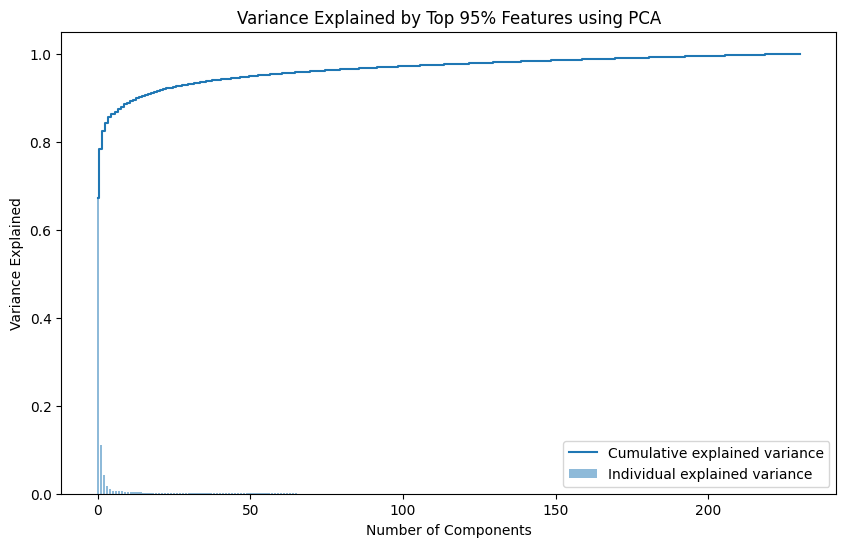

In [76]:
# get variance explained for features_hog_template_pca
hog_template_variance_pca = get_variance_explained(features_hog_template_pca)
title_pca = "Variance Explained by Top 95% Features using PCA"
plot_variance_compare(hog_template_variance_pca, title_pca)


In [77]:
# select the top components in features_Hue_hog_template that explain 95% of the variance
pca_hue_hog_template_file = Path("data/pca_hue_hog_template.joblib")
if not pca_hue_hog_template_file.exists():
    pca = PCA(n_components=0.95)
    pca.fit(features_hue_hog_template)
    joblib.dump(pca, pca_hue_hog_template_file)
else:
    pca = joblib.load(pca_hue_hog_template_file)
print("Number of components that explain 95% of the variance:", pca.n_components_)

features_hue_hog_template_pca = pca.transform(features_hue_hog_template)
print("Shape of features_hue_hog_template_pca:", features_hue_hog_template_pca.shape)

# save features_hue_hog_template_pca to a csv file
features_hue_hog_template_pca_file = Path("data/features_hue_hog_template_pca.csv")
if not features_hue_hog_template_pca_file.exists():
    np.savetxt(features_hue_hog_template_pca_file, features_hue_hog_template_pca, delimiter=",")    
else:
    features_hue_hog_template_pca = np.loadtxt(features_hue_hog_template_pca_file, delimiter=",")
print("Shape of features_hue_hog_template_pca:", features_hue_hog_template_pca.shape)



Number of components that explain 95% of the variance: 22
Shape of features_hue_hog_template_pca: (8600, 22)
Shape of features_hue_hog_template_pca: (8600, 22)


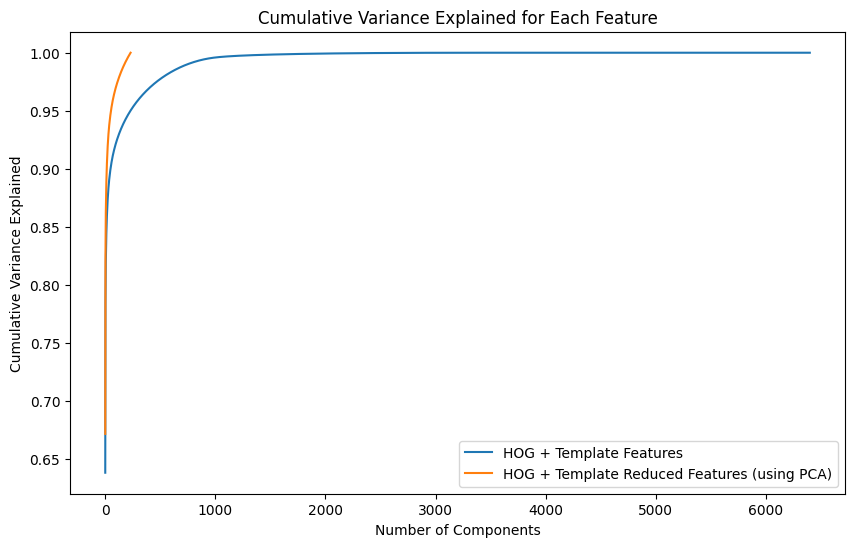

In [51]:
#plot hog_template_variance_pca and hog_template_variance in the same plot
sub_variance_list_2 = [
    hog_template_variance,
    hog_template_variance_pca,
    hue_hog_temp_variance,
    
]
title_3 = [
    "HOG + Template Features",
    "HOG + Template Reduced Features (using PCA)",
    
]

plot_variance_visual(sub_variance_list_2, title_3)

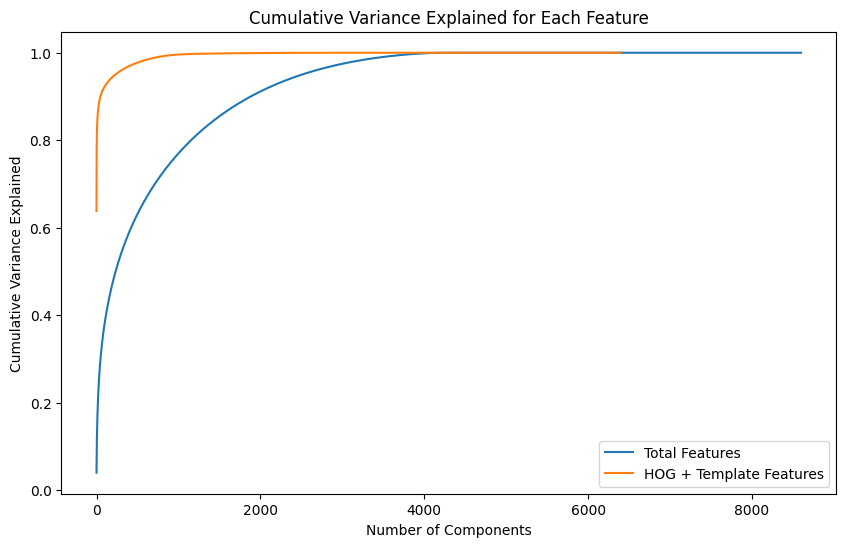

In [54]:
# plot total_variance_pca and total_variance in the same plot
sub_variance_list_4 = [
    total_variance,
    hog_template_variance,
]
title_4 = [
    "Total Features",
    "HOG + Template Features",
    
]

plot_variance_visual(sub_variance_list_4, title_4)

### T-distributed Stochastic Neighbor Embedding (t-SNE) Visualization

In [56]:
tsne = TSNE(
    n_components=2, random_state=42, verbose=1
)  # remove verbose=1 if you do not want to see the progress bar

In [81]:
# apply TSNE to individual and combined features
tsne_results_file = Path("data/tsne_results.joblib")
if not tsne_results_file.exists():
    hue_tsne = tsne.fit_transform(hue)
    saturation_tsne = tsne.fit_transform(saturation)
    lbp_tsne = tsne.fit_transform(lbp)
    hog_tsne = tsne.fit_transform(hog)
    template_tsne = tsne.fit_transform(template)
    hog_template_tsne = tsne.fit_transform(features_hog_template)
    hue_hog_template_tsne = tsne.fit_transform(features_hue_hog_template)
    hog_template_pca_tsne = tsne.fit_transform(features_hog_template_pca)
    total_tsne = tsne.fit_transform(features_total)
    total_reduced_pca_tsne = tsne.fit_transform(features_total_pca)
    
    # total_reduced_tsne = tsne.fit_transform(features_total_reduced)
    # total_reduced_pca_tsne = tsne.fit_transform(features_total_reduced_pca)
    joblib.dump(
        {
            "hue_tsne": hue_tsne,
            "sat_tsne": saturation_tsne,
            "lbp_tsne": lbp_tsne,
            "hog_tsne": hog_tsne,
            "tem_tsne": template_tsne,
            "hog_tem_tsne": hog_template_tsne,
            "hog_tem_pca_tsne": hog_template_pca_tsne,
            "hue_hog_temp_tsne": hue_hog_template_tsne,
            "tot_tsne": total_tsne,
            "tot_reduced_pca_tsne": total_reduced_pca_tsne,
        },
        tsne_results_file,
    )
else:
    loaded_tsne = joblib.load(tsne_results_file)
    hue_tsne = loaded_tsne["hue_tsne"]
    saturation_tsne = loaded_tsne["sat_tsne"]
    lbp_tsne = loaded_tsne["lbp_tsne"]
    hog_tsne = loaded_tsne["hog_tsne"]
    template_tsne = loaded_tsne["tem_tsne"]
    hog_template_tsne = loaded_tsne["hog_tem_tsne"]
    hog_template_pca_tsne = loaded_tsne["hog_tem_pca_tsne"]
    hue_hog_template_tsne = loaded_tsne["hue_hog_temp_tsne"]
    total_tsne = loaded_tsne["tot_tsne"]
    total_reduced_pca_tsne = loaded_tsne["tot_reduced_pca_tsne"]

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8600 samples in 0.023s...
[t-SNE] Computed neighbors for 8600 samples in 0.145s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8600
[t-SNE] Computed conditional probabilities for sample 2000 / 8600
[t-SNE] Computed conditional probabilities for sample 3000 / 8600
[t-SNE] Computed conditional probabilities for sample 4000 / 8600
[t-SNE] Computed conditional probabilities for sample 5000 / 8600
[t-SNE] Computed conditional probabilities for sample 6000 / 8600
[t-SNE] Computed conditional probabilities for sample 7000 / 8600
[t-SNE] Computed conditional probabilities for sample 8000 / 8600
[t-SNE] Computed conditional probabilities for sample 8600 / 8600
[t-SNE] Mean sigma: 121.612869
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.760765
[t-SNE] KL divergence after 1000 iterations: 1.917870
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8600 samples in 0.006s...
[t-SNE] Computed n

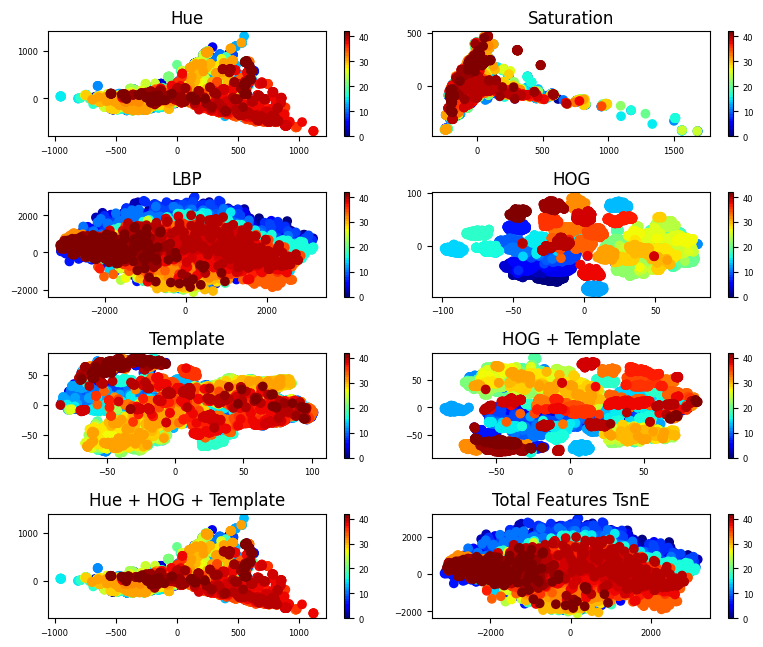

In [82]:
# features_list = [hue_tsne, saturation_tsne, value_tsne, lbp_tsne, hog_tsne, total_tsne, total_reduced_tsne, total_reduced_pca_tsne]
# title_list = ["Hue", "Saturation", "Value", "LBP", "HOG", "All Features", "Reduced Features", "Reduced Features (after PCA)"]

features_list = [
    hue_tsne,
    saturation_tsne,
    lbp_tsne,
    hog_tsne,
    template_tsne,
    hog_template_tsne,
    hue_hog_template_tsne,
    total_tsne,
    # total_reduced_pca_tsne,
]
title_list = [
    "Hue",
    "Saturation",
    "LBP",
    "HOG",
    "Template",
    "HOG + Template",
    "Hue + HOG + Template",
    "Total Features TsnE",
    # "Total Reduced Features (PCA) TSNE",
]


# define a function to plot TSNE results for 6 features, 2 rows and 4 columns
def plot_tsne(features_list, title_list):
    fig = plt.figure(figsize=(8, 8))
    for i in range(len(features_list)):
        plt.subplot(5, 2, i + 1)
        plt.scatter(
            features_list[i][:, 0],
            features_list[i][:, 1],
            c=dft["ClassId"],
            cmap=plt.cm.get_cmap("jet", 43),
        )
        # plt.colorbar(ticks=range(43))
        # plt.clim(-0.5, 42.5)
        # change the colorbar label font size
        cbar = plt.colorbar()
        cbar.ax.tick_params(labelsize=6)
        # change font size for x and y ticks
        plt.xticks(fontsize=6)
        plt.yticks(fontsize=6)
        plt.title(title_list[i])
        #show x and y axis labels

    plt.tight_layout()
    plt.show()


plot_tsne(features_list, title_list)